# DATA 643: Recommender Systems
Final Project:  Book Crossing RecSys | Walt Wells, Summer 2017

# Notebook P3 - Model | Factorization

# Environment Prep

In [1]:
suppressMessages(library(Matrix))
suppressMessages(library(recommenderlab))
suppressMessages(library(ggplot2))
suppressMessages(library(rARPACK))
suppressMessages(library(reshape2))
source('helper.R')

# Data Prep

In [2]:
BinBook <- readRDS("binBookM.rds")
Book <- readRDS("BookM.rds")

In [3]:
SparseM <- as(Book, "dgCMatrix")
SparseMBin <- as(BinBook, "dgCMatrix")

# SVD

Since we are dealing with large and sparse matrices, we will use the Truncated SVD method available in the rARPACK library. 

## Helper:  Variability Table

In [4]:
SVDRemoveTable <- function(s) {
    df <- data.frame()
    for (i in seq(nrow(s))) {
        m <- sum(s[1:i, 1:i]^2)/sum(s^2)
        df <- rbind(df, c(i, m))
    }
    names(df) <- c("concepts", "variability")
    df
}

## Sample:   Test SVDs 

In [5]:
k <- 25
x <- svds(SparseM, k)

In [6]:
str(x)
SMat <- diag(x$d)
U <- x$u
V <- x$v

List of 5
 $ d    : num [1:25] 55.9 49.7 40.7 39.3 38.7 ...
 $ u    : num [1:33095, 1:25] 2.99e-09 -4.79e-19 3.06e-19 -2.99e-20 1.88e-09 ...
 $ v    : num [1:95795, 1:25] 1.01e-08 8.12e-11 -6.64e-15 0.00 5.97e-09 ...
 $ niter: int 6
 $ nops : int 269


### Review relationship between k and variability

In [7]:
mytable <- SVDRemoveTable(SMat)

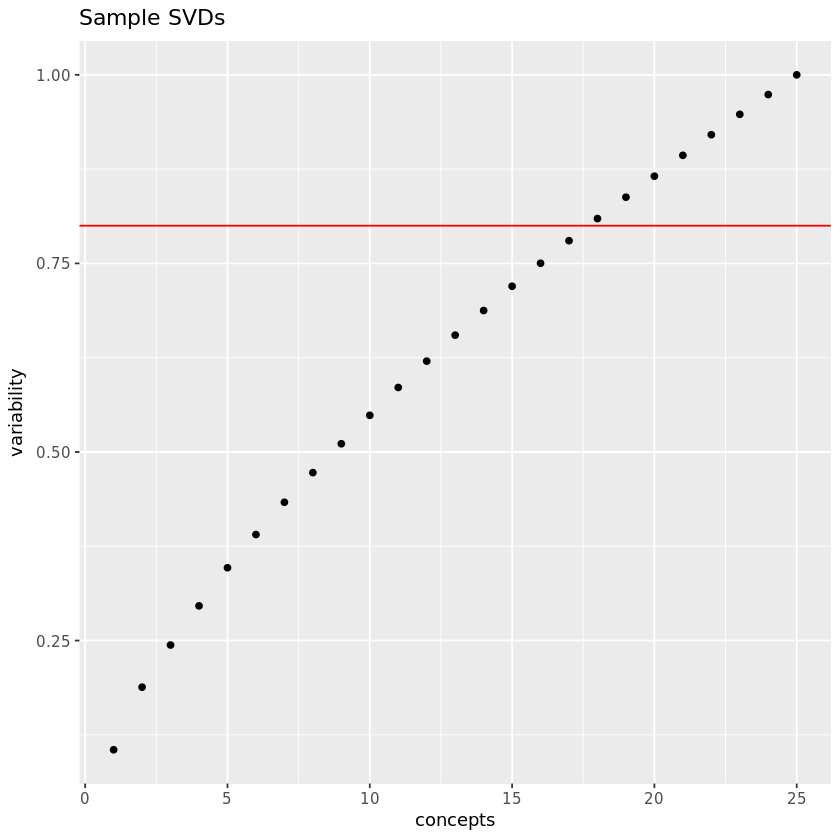

In [8]:
ggplot(mytable, aes(concepts, variability)) + geom_point() + 
    geom_hline(yintercept = .80, color='red') + 
    ggtitle("Sample SVDs")

### Factorized Matrix

In [9]:
n <- .8 * k

NewSMat <- SMat[1:n, 1:n]
NewU <- U[,1:n]
NewV <- V[,1:n]

PreComputed <- NewSMat %*% t(NewV)

In [10]:
getSizeDim(SparseM)
getSizeDim(NewSMat)
getSizeDim(NewU)
getSizeDim(NewV)
getSizeDim(PreComputed)

[1] "Object SparseM size: 20.905 MB |  Dim: 33095 95795"
[1] "Object NewSMat size: 0.003 MB |  Dim: 20 20"
[1] "Object NewU size: 5.05 MB |  Dim: 33095 20"
[1] "Object NewV size: 14.617 MB |  Dim: 95795 20"
[1] "Object PreComputed size: 14.617 MB |  Dim: 20 95795"


### Make Sample Prediction

In [11]:
#r_bar <- colMeans(Book)
samp <- sample(nrow(NewU),1)
q <- NewU[samp,]
#SampleUserActual <- Book[samp,]

In [12]:
qV <- q %*% PreComputed

In [13]:
ItemIndex <- SparseM@Dimnames[2]
qV <- data.frame(ItemIndex, t(qV))
colnames(qV) <- c("ISBN", "Prediction")

In [14]:
n <- 10
sorted_qV <- qV[order(-qV$Prediction), ]
head(sorted_qV, n)

,ISBN,Prediction
30737,0441005667,1.026790e-16
40351,0553250426,1.016320e-16
13351,031298328X,9.881666e-17
11840,0312195516,9.638884e-17
27165,0415900522,9.083199e-17
47607,0671697994,8.826365e-17
30648,0441000916,8.588411e-17
15849,0345333926,8.418429e-17
4182,0064400557,7.877593e-17
40469,0553258524,7.831968e-17


In [15]:
#saveRDS(PreComputed, "SVDOutput.rds")

# Evaluation

## Get RMSE by Reducing Matrix Size

I couldn't find a good way to evalute these that wasn't too memory intensive.   As a result, we'll predict instead over a subset of books and users, and calculate the RMSE from a more manageable subset.  After going through the simple exercise of calculating RMSE based on a single sample, we will take multiple samples, calculate the RMSE for each, and choose the best methods.  

In [16]:
N <- 5000
startV <- sample(1:nrow(SparseM), 50)
startU <- sample(1:ncol(SparseM), 50)
SubU <- NewU[1:N,]
SubV <- NewV[1:N,]
PredSamp <- SubU %*% NewSMat %*% t(SubV)
getSizeDim(PredSamp)

[1] "Object PredSamp size: 190.735 MB |  Dim: 5000 5000"


In [17]:
KnownSamp <- as(Book[1:N, 1:N], 'matrix')
getSizeDim(KnownSamp)

[1] "Object KnownSamp size: 191.307 MB |  Dim: 5000 5000"


In [18]:
PredSamp[is.na(KnownSamp)] <- NA

In [19]:
RMSE <- function(observed, predicted) {
    # get RMSE
    sqrt(mean((observed - predicted)^2, na.rm=TRUE))
}

In [20]:
RMSE(KnownSamp, PredSamp)

[1] 1.357277

## Run Simulations

These rely on two functions:   GetSVDsRMSE and simMeans.   It was easier to ultimately run the sims as a separate .R file (see FactorizationSims.R) and then export the time and the results.   Below we import and do some basic visualization to intepret the best model.  

Below is an example of the simultation output (including print logging to help understand timing).

In [21]:
sapply(c(3,5), 
       GetSVDsRMSE, 
       N_subset = 5000, 
       N_sims = 2,
       SparseMatrix = SparseM, 
       keepVar = .70)

[1] "SparseM | keepVar: 0.7 | k: 3"
[1] "SparseM | keepVar: 0.7 | k: 5"


1.37416,1.377978
1.462733,1.442101


## Load the Full Sim

In [22]:
simresults <- readRDS('simresults.rds')
simtime <- readRDS('simtime.rds')
head(simresults)

,k,Ex_Var70,Ex_Var80,Ex_Var90,Im_Var70,Im_Var80,Im_Var90
5,5,1.404057,1.390851,1.395770,1.413948,1.426140,1.422636
6,6,1.388519,1.389461,1.390985,1.436354,1.421615,1.423278
7,7,1.381160,1.392894,1.391213,1.439246,1.416478,1.419348
8,8,1.394408,1.399927,1.397402,1.423748,1.414054,1.413882
9,9,1.377394,1.371365,1.367540,1.423045,1.413126,1.421994
10,10,1.377552,1.381501,1.380880,1.414394,1.405908,1.433734


In [23]:
print(paste0("It took ", round(simtime[3]/60/60, 4), " hours to run these simulations."))

[1] "It took 35.6986 hours to run these simulations."


In [24]:
longSim <- melt(simresults, id="k")

## Plot Results

`geom_smooth()` using method = 'loess'


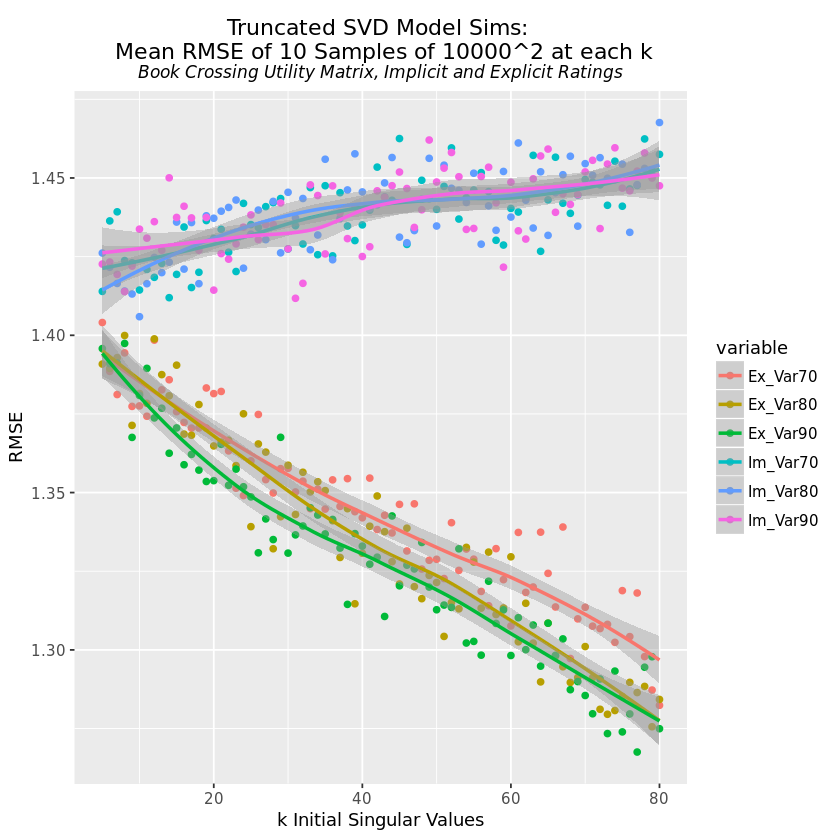

In [48]:
ggplot(longSim, aes(x=k, y=value, colour=variable)) + geom_point() + geom_smooth() + 
    #ylab("RMSE") + xlab("k Initial Singular Values") + 
    labs(x="k Initial Singular Values", 
              y="RMSE",
              title="Truncated SVD Model Sims: \n Mean RMSE of 10 Samples of 10000^2 at each k",
              subtitle="Book Crossing Utility Matrix, Implicit and Explicit Ratings")+
    theme(plot.title = element_text(hjust =0.5, vjust = -1),
         plot.subtitle=element_text(hjust=0.5, face="italic"))